# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


### Initialize Libraries

In [1]:
import netCDF4 as nc4;        import pandas as pd
import requests;              import json;
import matplotlib as mpl;     import matplotlib.pyplot as plt
import matplotlib.tri as tri; import pathlib as pl
import cartopy.crs as ccrs;   import cartopy.io.img_tiles as cart_img
import cartopy as cart;       import cartopy.io.img_tiles as cimgt
import numpy as np;           import wse
import skill_metrics as sm;   import geopandas as gpd
import calendar;              import wse
import skill_metrics as sm;   import seaborn as sns
import matplotlib.colors as mcolors
from shapely import Polygon,Point,MultiPoint,LineString,MultiLineString;import shapely.vectorized
from scipy.stats import linregress
from sklearn.metrics import root_mean_squared_error
from sklearn.neighbors import BallTree


salloc --ntasks=40 --nodes=1 --partition=normal --mem-per-cpu=8GB --time=06:00:00

source $HOME/miniforge3/bin/activate

### Defined Functions

#### Data for this exercise can be found here
https://doi.org/10.17603/ds2-h0fw-2p96

Download the swan_HS.63.nc from one of the 4 folders

---

### Initialize path and read netcdf file

In [2]:
root = pl.Path('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database/Raw_DATA')

#ncfile = nc4.Dataset(root / '2023' /'outputs' / 'fort.63.nc')

In [ ]:
obs_dir = pl.Path("/scratch/tmiesse/project/noaa_data/historic")
model_dir = pl.Path("/scratch/tmiesse/project/model_data/historical")
mapping_df = pd.read_csv(obs_dir / "station_model_node_mapping.csv").set_index("id")
mapping_df["lat"] = mapping_df["lat"].astype(float)
mapping_df["lon"] = mapping_df["lon"].astype(float)

# Define model years available
available_years = [y for y in range(1995, 2025) if (root / str(y)).exists()]

# Build BallTree on mesh (using one representative year)
with nc4.Dataset(str(root / f"{available_years[0]}/outputs/fort.63.nc")) as ds:
    model_lats = ds.variables["y"][:]
    model_lons = ds.variables["x"][:]
tree = BallTree(np.deg2rad(np.c_[model_lats, model_lons]), metric="haversine")

K = 5  # number of neighbors to try

for station_id, row in mapping_df.iterrows():
    model_csv = model_dir / f"{station_id}_model_hourly_wse.csv"

    # 1) If a model CSV exists and has ANY non-null data, skip re-extracting
    if model_csv.exists():
        df_m_exist = pd.read_csv(model_csv)
        if df_m_exist["data"].notna().sum() > 0:
            print(f"{station_id}: existing model CSV has data; skipping")
            continue
        else:
            print(f"{station_id}: existing model CSV empty; re-extracting")

    # 2) Load raw NOAA obs and determine time window
    obs_file = next(obs_dir.glob(f"{station_id}_*.csv"), None)
    if obs_file is None:
        print(f"{station_id}: no obs file; skipping")
        continue

    df_obs = pd.read_csv(obs_file)
    # detect datetime/value columns
    tcol = next((c for c in df_obs.columns if c.lower()=="t" or "date" in c.lower()), None)
    vcol = next((c for c in df_obs.columns if c.lower()=="v" or c.lower()=="data"), None)
    if tcol is None or vcol is None:
        print(f"{station_id}: cannot detect t/v columns; skipping")
        continue

    df_obs[tcol] = pd.to_datetime(df_obs[tcol], errors="coerce", utc=True)
    df_obs[vcol] = pd.to_numeric(df_obs[vcol], errors="coerce")
    df_obs = df_obs.dropna(subset=[tcol, vcol])
    if df_obs.empty:
        print(f"{station_id}: obs file has no valid rows; skipping")
        continue

    start_dt = df_obs[tcol].min()
    end_dt   = df_obs[tcol].max()
    # restrict to available model years
    obs_years = set(range(start_dt.year, end_dt.year + 1))
    years_to_try = sorted(obs_years & set(available_years))
    if not years_to_try:
        print(f"{station_id}: obs window outside model years; skipping")
        continue

    # 3) Find the best of the K nearest nodes by counting non-NaNs
    lat, lon = row["lat"], row["lon"]
    _, neighbors = tree.query(np.deg2rad([[lat, lon]]), k=K)
    best_node, best_count = None, -1

    for node in neighbors[0]:
        cnt = 0
        for yr in years_to_try:
            nc_path = root / f"{yr}/outputs/fort.63.nc"
            if not nc_path.exists(): 
                continue
            with nc4.Dataset(str(nc_path)) as ds:
                base = ds.variables["time"].getncattr("base_date")
                t0   = pd.to_datetime(base, utc=True)
                nt   = ds.dimensions["time"].size
                times = pd.date_range(start=t0, freq="1h", periods=nt, tz="UTC")
                mask  = (times >= start_dt) & (times <= end_dt)
                if mask.any():
                    series = ds.variables["zeta"][mask, node]
                    cnt   += np.count_nonzero(~np.isnan(series))
        if cnt > best_count:
            best_count, best_node = cnt, node

    if best_count <= 0:
        print(f"{station_id}: no valid data at any of the {K} nearest nodes; skipping")
        continue

    print(f"{station_id}: selecting node {best_node} with {best_count} valid points")

    # 4) Extract & save the series for best_node
    frames = []
    for yr in years_to_try:
        nc_path = root / f"{yr}/outputs/fort.63.nc"
        if not nc_path.exists():
            continue
        with nc4.Dataset(str(nc_path)) as ds:
            base = ds.variables["time"].getncattr("base_date")
            t0   = pd.to_datetime(base, utc=True)
            nt   = ds.dimensions["time"].size
            times = pd.date_range(start=t0, freq="1h", periods=nt, tz="UTC")
            mask  = (times >= start_dt) & (times <= end_dt)
            if mask.any():
                data = ds.variables["zeta"][mask, best_node]
                frames.append(pd.DataFrame({"dt": times[mask], "data": data}))

    if frames:
        df_all = pd.concat(frames, ignore_index=True)
        df_all.to_csv(model_csv, index=False)
        print(f"{station_id}: wrote {len(df_all)} rows to {model_csv.name}")
    else:
        print(f"{station_id}: extraction yielded no rows despite best_count>0")

9499176: existing model CSV empty; re-extracting
9499176: selecting node 509294 with 1729 valid points
9499176: wrote 1729 rows to 9499176_model_hourly_wse.csv
9498381: no obs file; skipping
9497147: no obs file; skipping
9494935: existing model CSV has data; skipping
9494212: existing model CSV has data; skipping
9494168: existing model CSV has data; skipping
9493291: existing model CSV empty; re-extracting


In [3]:
manual_node = {
#    "9499176": 520661,
#    "9498381": 333747,
#    "9490424": 819726,
    "9469751": 824701,
    "9490096": 815651,
    "9469854": 778593,
    "9469439": 734720,
    "9468151": 319218,
    "9466931": 494553
}

In [ ]:
import pytz
from datetime import datetime
HIST_OBS_DIR   = pl.Path('/scratch/tmiesse/project/noaa_data/historic')
# Directory to save extracted model time series
OUT_MODEL_DIR  = pl.Path('/scratch/tmiesse/project/model_data/historical')
OUT_MODEL_DIR.mkdir(parents=True, exist_ok=True)
# Station→node mapping you created earlier
MAPPING_CSV    = pl.Path('/scratch/tmiesse/project/noaa_data/historic/station_model_node_mapping.csv')

# ADCIRC outputs root (organized by year)
ADCIRC_ROOT    = pl.Path('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database/Raw_DATA')

# Alaska timezone
AK_TZ = pytz.timezone('America/Anchorage')
# --- Helper to read station date window from your obs CSV header or metadata CSV ---  
def get_station_dates(obs_csv: pl.Path):
    """Read first/last observation timestamps from existing CSV."""
    df = pd.read_csv(obs_csv, parse_dates=['t'])
    return df['t'].min().to_pydatetime(), df['t'].max().to_pydatetime()

# --- Load mapping of stations to model nodes ---
stations_df = pd.read_csv(MAPPING_CSV, dtype={'id': str})
# Expect columns: station_id, name, model_node

for _, row in stations_df.iterrows():
    stn = row['id']
    name = row['name']
    node = manual_node.get(stn, int(row['model_node']))
    obs_csv = next(HIST_OBS_DIR.glob(f"{stn}_*.csv"), None)
    if obs_csv is None:
        print(f"⚠ No obs CSV found for {stn}, skipping.")
        continue
    # get the actual observation date window
    start_dt, end_dt = get_station_dates(obs_csv)
    # clip to model coverage
    start_dt = max(start_dt, datetime(1998,1,1))
    end_dt   = min(end_dt,   datetime(2024,12,31))
    print(f"Extracting model for {stn} ({name}) from {start_dt.date()} to {end_dt.date()} at node {node}")

    all_dfs = []
    for year in range(start_dt.year, end_dt.year + 1):
        nc_path = ADCIRC_ROOT / str(year) / 'outputs' / 'fort.63.nc'
        if not nc_path.exists():
            continue

        with nc4.Dataset(nc_path) as ds:
            # build time index
            base = ds.variables['time'].base_date     # e.g. '2023-01-01 00:00:00 UTC'
            base_dt = pd.to_datetime(base)  
            times = pd.date_range(
                start=base_dt, 
                periods=ds.dimensions['time'].size, 
                freq='1h', 
                tz=pytz.UTC
            ).tz_convert(AK_TZ)

            # extract water‑surface elevation
            zeta = ds.variables['zeta'][:, node]

        df = pd.DataFrame({'dt': times, 'model_wse': zeta})
        # slice to station's window
        mask = (df['dt'] >= pd.Timestamp(start_dt, tz=AK_TZ)) & \
               (df['dt'] <= pd.Timestamp(end_dt,   tz=AK_TZ))
        df = df.loc[mask]
        if not df.empty:
            all_dfs.append(df)

    if all_dfs:
        result = pd.concat(all_dfs, ignore_index=True)
        out_csv = OUT_MODEL_DIR / f"{stn}_{name}.csv"
        result.to_csv(out_csv, index=False)
        print(f" ✔ Saved {out_csv} ({len(result)} rows)")
    else:
        print(f" ⚠ No model data in range for {stn}")

Extracting model for 9499176 (Barter Island) from 2008-01-15 to 2008-10-26 at node 486429


In [ ]:
def point_lookup(model_lat: np.array, model_lon: np.array,
                 station_lat: np.array, station_lon: np.array):
    tree = BallTree(np.deg2rad(np.c_[model_lat, model_lon]), metric='haversine')
    distances, indices = tree.query(np.deg2rad(np.c_[station_lat, station_lon]), k=1)
    return distances.flatten() * 6371, indices.flatten()  # km, node index
station_csv = "/scratch/tmiesse/project/noaa_data/alaska_historic_station_coords.csv"
stations_df = pd.read_csv(station_csv)

# Load model lat/lon from ADCIRC NetCDF
model_nc = root / "2023" / "outputs" / "fort.63.nc"
with nc4.Dataset(model_nc) as ds:
    model_lat = ds["y"][:]  # shape (nodes,)
    model_lon = ds["x"][:]  # shape (nodes,)

# Run nearest-node lookup
dists_km, node_ids = point_lookup(
    model_lat=model_lat,
    model_lon=model_lon,
    station_lat=stations_df["lat"].values,
    station_lon=stations_df["lon"].values
)

stations_df["model_node"] = node_ids
stations_df["distance_km"] = dists_km

# Save output with model node mapping
stations_df.to_csv("/scratch/tmiesse/project/noaa_data/station_model_node_mapping.csv", index=False)
print("✔ Saved station-to-model node mapping.")

✔ Saved station-to-model node mapping.


#### Read metadata within netcdf file

_____________________________________

In [3]:
obs_dir = pl.Path("/scratch/tmiesse/project/noaa_data")
out_dir = pl.Path("/scratch/tmiesse/project/model_data")
out_dir.mkdir(parents=True, exist_ok=True)
root = pl.Path('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database/Raw_DATA')
mapping_df = pd.read_csv(obs_dir / 'historic' /"station_model_node_mapping.csv").set_index("id")


for csv_path in obs_dir.glob("*_*.csv"):
    try:
        station_id = int(csv_path.stem.split("_")[0])
    except:
        print(f"⚠ Skipping invalid filename: {csv_path.name}")
        continue

    if station_id not in mapping_df.index:
        print(f"⚠ No node mapping for station {station_id}")
        continue

    node = int(mapping_df.loc[station_id, "model_node"])
    station_name = mapping_df.loc[station_id, "name"].replace(" ", "_").replace(",", "").lower()

    # Read observation file and detect time column
    try:
        df_obs = pd.read_csv(csv_path)
    except Exception as e:
        print(f"⚠ Failed to read {csv_path.name}: {e}")
        continue

    time_col = next((col for col in df_obs.columns if "date" in col.lower() or col.lower() == "t"), None)
    if not time_col:
        print(f"⚠ No datetime column found in {csv_path.name}")
        continue

    # Parse as UTC‐aware timestamps
    df_obs[time_col] = pd.to_datetime(df_obs[time_col], errors="coerce", utc=True)
    df_obs = df_obs.dropna(subset=[time_col])
    if df_obs.empty:
        print(f"⚠ No valid timestamps in {csv_path.name}")
        continue

    start_dt = df_obs[time_col].min()
    end_dt   = df_obs[time_col].max()
    needed_years = list(range(start_dt.year, end_dt.year + 1))
    print(f"\n📡 {station_id} - {station_name}: {start_dt.date()} to {end_dt.date()} (node {node})")

    model_data = []

    for year in needed_years:
        nc_path = root / f"{year}/outputs/fort.63.nc"
        if not nc_path.exists():
            print(f"  ⚠ Missing file: {nc_path}")
            continue

        with nc4.Dataset(str(nc_path)) as ds:
            try:
                # === YOUR PREFERRED TIME VECTOR ===
                base = ds.variables['time'].base_date
                start = pd.to_datetime(base, utc=True)
                nt = ds.dimensions['time'].size
                model_times = pd.date_range(start=start, freq='1h', periods=nt, tz='UTC')
                # ==================================

                mask = (model_times >= start_dt) & (model_times <= end_dt)
                if not mask.any():
                    continue

                zeta = ds.variables['zeta'][mask, node]
                df_year = pd.DataFrame({
                    "dt": model_times[mask],
                    "data": zeta
                })
                model_data.append(df_year)
                print(f"  ✓ Extracted {len(df_year)} records from {year}")

            except Exception as e:
                print(f"  ⚠ Error reading {nc_path.name}: {e}")

    if model_data:
        df_out = pd.concat(model_data, ignore_index=True)
        out_path = out_dir / f"{station_id}_model_hourly_wse.csv"
        df_out.to_csv(out_path, index=False)
        print(f"  ✔ Saved to {out_path.name}")
    else:
        print(f"  ⚠ No model data found for station {station_id}")
    try:
        station_id = int(csv_path.stem.split("_")[0])
    except:
        print(f"⚠ Skipping invalid filename: {csv_path.name}")
        continue

    if station_id not in mapping_df.index:
        print(f"⚠ No node mapping for station {station_id}")
        continue

    node = int(mapping_df.loc[station_id, "model_node"])
    station_name = mapping_df.loc[station_id, "name"].replace(" ", "_").replace(",", "").lower()

    # Read observation file and detect time column
    try:
        df_obs = pd.read_csv(csv_path)
    except Exception as e:
        print(f"⚠ Failed to read {csv_path.name}: {e}")
        continue

    time_col = next((col for col in df_obs.columns if "date" in col.lower() or col.lower() == "t"), None)
    if not time_col:
        print(f"⚠ No datetime column found in {csv_path.name}")
        continue

    df_obs[time_col] = pd.to_datetime(df_obs[time_col], errors="coerce")
    df_obs = df_obs.dropna(subset=[time_col])
    if df_obs.empty:
        print(f"⚠ No valid timestamps in {csv_path.name}")
        continue

    start_dt = df_obs[time_col].min()
    end_dt = df_obs[time_col].max()
    needed_years = list(range(start_dt.year, end_dt.year + 1))
    print(f"\n📡 {station_id} - {station_name}: {start_dt.date()} to {end_dt.date()} (node {node})")

    model_data = []

    for year in needed_years:
        nc_path = root / f"{year}/outputs/fort.63.nc"
        if not nc_path.exists():
            print(f"  ⚠ Missing file: {nc_path}")
            continue

        with nc4.Dataset(str(nc_path)) as ds:
            try:
                # Build the hourly datetime index from base_date and time dimension
                base = ds.variables['time'].getncattr('base_date')
                start = pd.to_datetime(base)
                nt = ds.dimensions['time'].size
                model_times = pd.date_range(start=start, freq='1H', periods=nt)

                # Mask for our station's observation window
                mask = (model_times >= start_dt) & (model_times <= end_dt)
                if not mask.any():
                    continue

                # Extract the zeta (WSE) at the nearest node
                zeta = ds.variables['zeta'][mask, node]

                df_year = pd.DataFrame({
                    "dt": model_times[mask],
                    "data": zeta
                })
                model_data.append(df_year)
                print(f"  ✓ Extracted {len(df_year)} records from {year}")

            except Exception as e:
                print(f"  ⚠ Error reading {nc_path.name}: {e}")

    if model_data:
        df_out = pd.concat(model_data, ignore_index=True)
        out_path = out_dir / f"{station_id}_model_hourly_wse.csv"
        df_out.to_csv(out_path, index=False)
        print(f"  ✔ Saved to {out_path.name}")
    else:
        print(f"  ⚠ No model data found for station {station_id}")
    try:
        station_id = int(csv_path.stem.split("_")[0])
    except:
        print(f"⚠ Skipping invalid filename: {csv_path.name}")
        continue

    if station_id not in mapping_df.index:
        print(f"⚠ No node mapping for station {station_id}")
        continue

    node = int(mapping_df.loc[station_id, "model_node"])
    station_name = mapping_df.loc[station_id, "name"].replace(" ", "_").replace(",", "").lower()

    # Read observation file and detect time column
    try:
        df_obs = pd.read_csv(csv_path)
    except Exception as e:
        print(f"⚠ Failed to read {csv_path.name}: {e}")
        continue

    time_col = next((col for col in df_obs.columns if "date" in col.lower() or col.lower() == "t"), None)
    if not time_col:
        print(f"⚠ No datetime column found in {csv_path.name}")
        continue

    df_obs[time_col] = pd.to_datetime(df_obs[time_col], errors="coerce")
    df_obs = df_obs.dropna(subset=[time_col])
    if df_obs.empty:
        print(f"⚠ No valid timestamps in {csv_path.name}")
        continue

    start_dt = df_obs[time_col].min()
    end_dt = df_obs[time_col].max()
    needed_years = list(range(start_dt.year, end_dt.year + 1))
    print(f"\n📡 {station_id} - {station_name}: {start_dt.date()} to {end_dt.date()} (node {node})")

    model_data = []

    for year in needed_years:
        nc_path = root / f"{year}/outputs/fort.63.nc"
        if not nc_path.exists():
            print(f"  ⚠ Missing file: {nc_path}")
            continue

        with nc4.Dataset(str(nc_path)) as ds:
            try:
                time_var = ds.variables["time"]
                model_times = nc4.num2date(time_var[:], time_var.units)
                mask = (model_times >= start_dt) & (model_times <= end_dt)
                if not np.any(mask):
                    continue
                zeta = ds.variables["zeta"][mask, node]
                df_year = pd.DataFrame({
                    "dt": model_times[mask],
                    "data": zeta
                })
                model_data.append(df_year)
                print(f"  ✓ Extracted {len(df_year)} records from {year}")
            except Exception as e:
                print(f"  ⚠ Error reading {nc_path.name}: {e}")

    if model_data:
        df_out = pd.concat(model_data, ignore_index=True)
        out_path = out_dir / f"{station_id}_model_hourly_wse.csv"
        df_out.to_csv(out_path, index=False)
        print(f"  ✔ Saved to {out_path.name}")
    else:
        print(f"  ⚠ No model data found for station {station_id}")

⚠ Skipping invalid filename: nome_mhhw.csv
⚠ Skipping invalid filename: nome_noaa.csv
⚠ Skipping invalid filename: nome_noaa_constituents.csv
⚠ Skipping invalid filename: nome_noaa_max.csv
⚠ Skipping invalid filename: prudhoe_mhhw.csv
⚠ Skipping invalid filename: prudhoe_noaa_constituents.csv
⚠ Skipping invalid filename: prudhoe_noaa_max.csv
⚠ Skipping invalid filename: red_mhhw.csv
⚠ Skipping invalid filename: red_noaa_constituents.csv
⚠ Skipping invalid filename: red_noaa_max.csv
⚠ Skipping invalid filename: unalakleet_mhhw.csv
⚠ Skipping invalid filename: unalakleet_noaa_constituents.csv
⚠ Skipping invalid filename: unalakleet_noaa_max.csv


In [ ]:
stations = {'prudhoe':{'id':9497645,'lat':70.421459,'lon':-148.546311},
            'red':{'id':9491094,'lat':67.573681,'lon':-164.070663},
            'nome':{'id':9468756,'lat':64.499170,'lon':-165.431689},
            'unalakleet':{'id':9468333,'lat':63.881322,'lon':-160.820145},
            'paul':{'id':9464212,'lat':57.228635,'lon':-170.241801}}
years = ['2024','2023','2022','2021','2020','2019',
         '2018','2017','2016','2015','2014','2013',
         '2012','2011','2010']
name = 'unalakleet'
df_daily_wse, df_hourly_wse, df_annual_max= wse.extract_model_wse_for_station(name,stations,years,root)
df_hourly_wse.to_csv(f'/scratch/tmiesse/project/model_data/{name}_model_hourly_wse.csv')

In [3]:
letters = ['a.', 'b.', 'c.', 'd.', 'e.', 'f.', 'g.', 'h.', 'i.', 'j.',
           'k.', 'l.', 'm.', 'n.', 'o.', 'p.', 'q.', 'r.', 's.', 't.',
           'u.', 'v.', 'w.', 'x.', 'y.', 'z.', 'aa.', 'ab.', 'ac.', 'ad.',
           'ae.', 'af.', 'ag.', 'ah.', 'ai.', 'aj.', 'ak.', 'al.', 'am.',
           'an.', 'ao.', 'ap.', 'aq.', 'ar.', 'as.', 'at.', 'au.', 'av.', 'aw.']

                             Station       Start         End      Bias  \
0                       Red Dog Dock  2003-08-30  2024-12-29 -0.033157   
1                        Prudhoe Bay  1993-12-14  2024-12-29 -0.055468   
2                               Nome  1993-12-14  2024-12-29 -0.123985   
3                         Unalakleet  2011-06-22  2024-11-30 -0.112350   
4                      Kulukak Point  2019-07-03  2019-09-25  0.078274   
5           Carter Bay Kuskokwim Bay  2011-05-28  2011-09-30 -0.150415   
6                          Kinak Bay  2016-06-10  2016-08-21 -0.158904   
7                         Dall Point  2007-06-13  2007-09-09  0.489472   
8         Nunam Iqua (Sheldon Point)  2011-06-18  2011-10-02  0.254582   
9         Stebbins Norton Sound East  2020-06-30  2020-09-25 -0.116472   
10                        Shaktoolik  2010-07-14  2010-08-23 -0.081046   
11  Golovin Golovnin Lagoon Entrance  2023-07-14  2023-08-19  0.006150   
12             Upper Golovnin Lagoon  

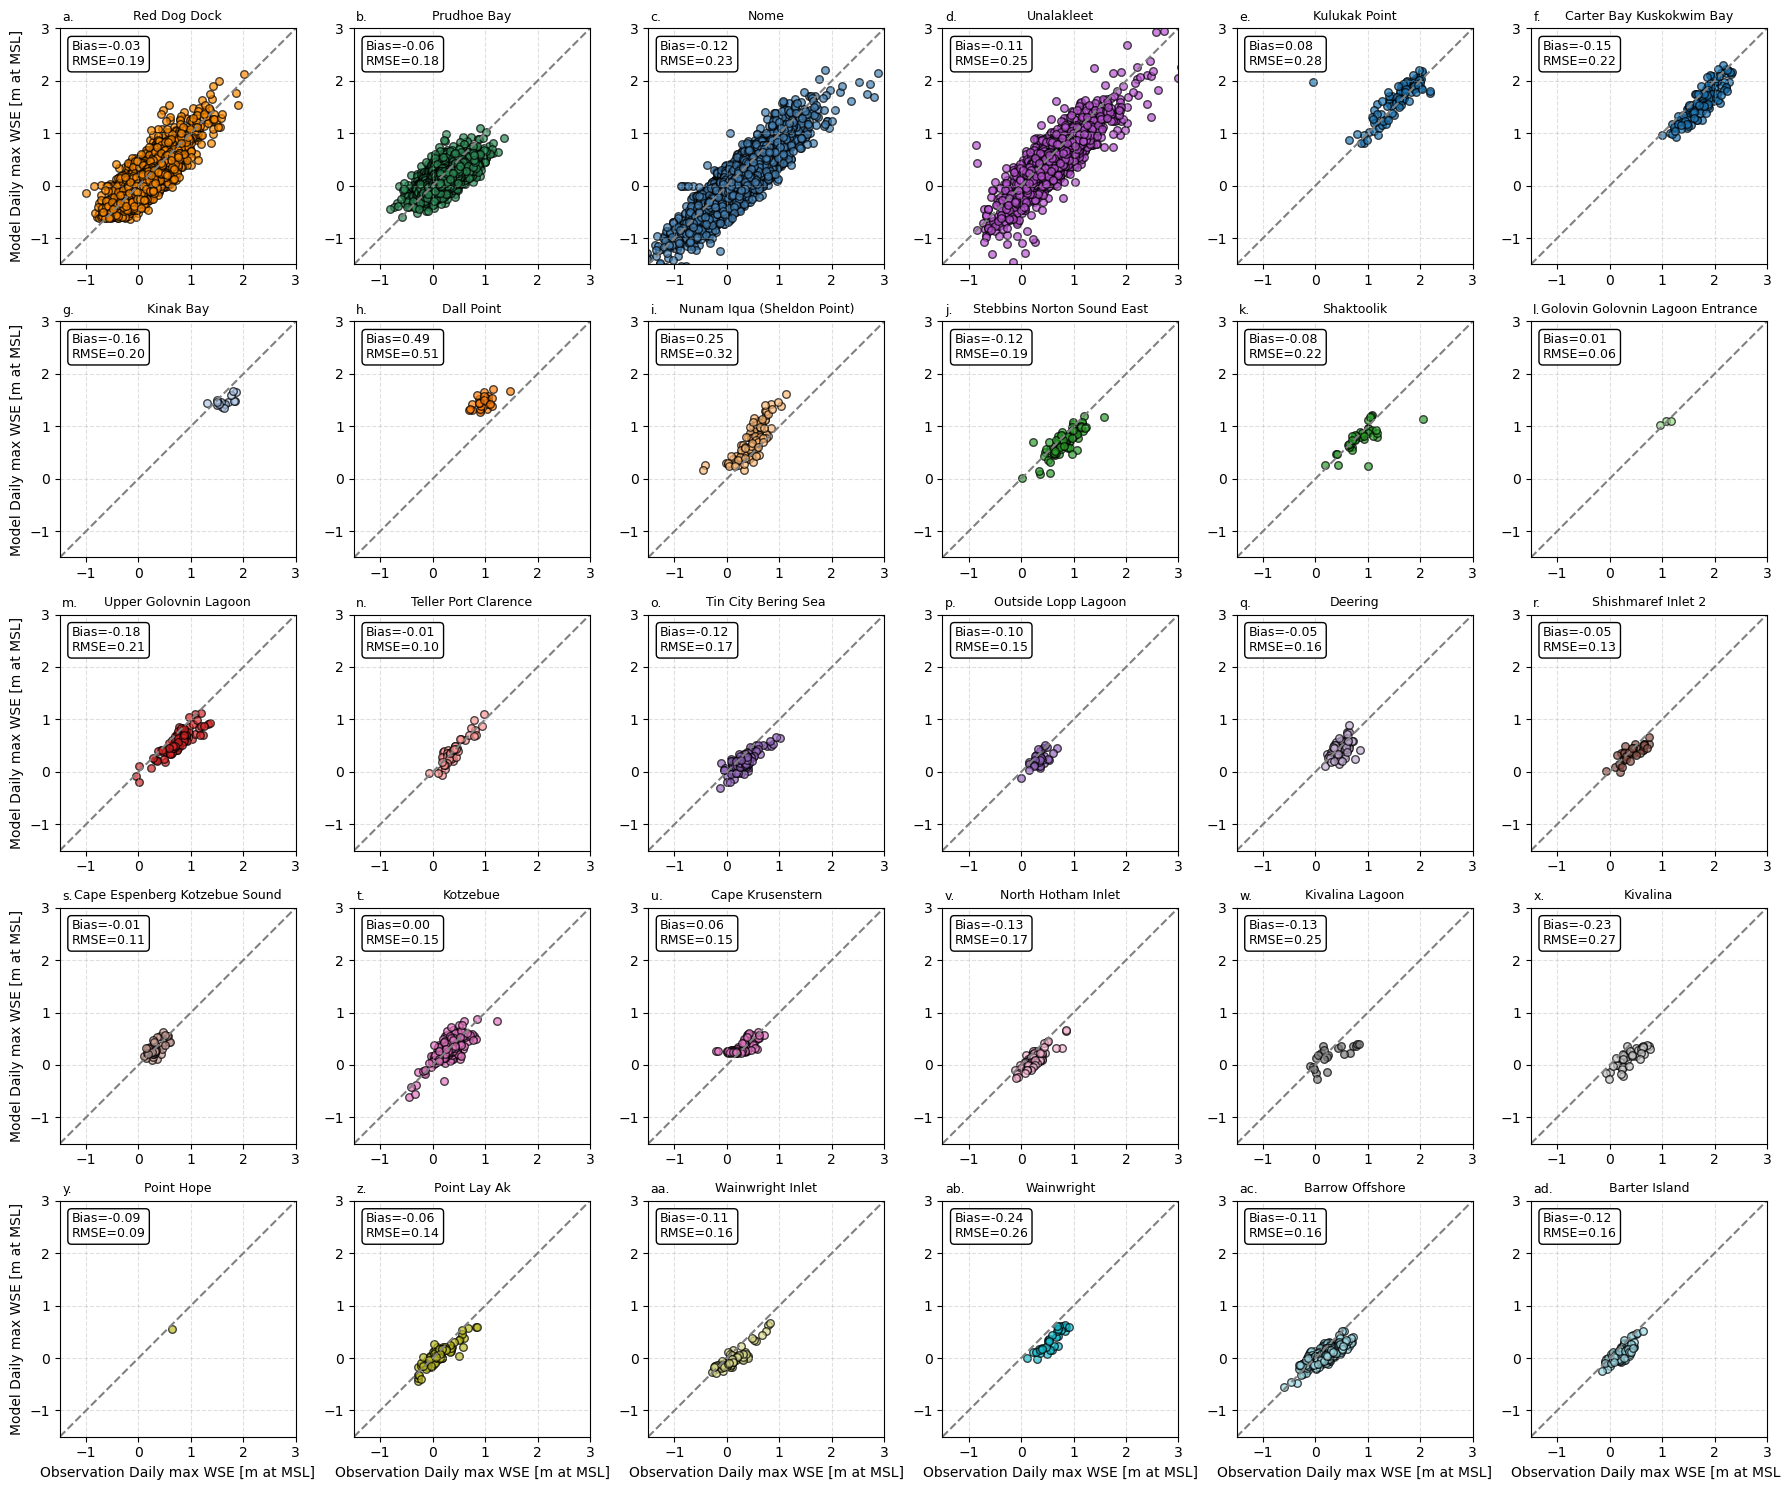

In [26]:

# 1) Discover all stations from the model files
hist_obs_dir = pl.Path("/scratch/tmiesse/project/noaa_data/historic")
hist_model_dir = pl.Path("/scratch/tmiesse/project/model_data/historical")

fig_dir = pl.Path("/scratch/tmiesse/project/figures")

ops_obs_dir    = pl.Path("/scratch/tmiesse/project/noaa_data")
ops_model_dir  = pl.Path("/scratch/tmiesse/project/model_data")
# where to save the figure
fig_dir        = pl.Path("/scratch/tmiesse/project/figures")
fig_dir.mkdir(parents=True, exist_ok=True)

# --- RMSE HELPER ---
def rmse(x, y):
    return np.sqrt(np.mean((x - y) ** 2))


# --- COLUMN DETECTION ---
def detect_time_value_cols(df):
    tcol = next((c for c in df.columns if c.lower() in ("t","time","date","datetime")), None)
    vcol = next((c for c in df.columns if c.lower() in ("v","value","data")), None)
    return tcol, vcol

# --- COLLECT STATIONS ---
stations = []  # list of (label, df_cmp)

# 1) Operational stations
operational = [
    {"key": "red",        "label": "Red Dog Dock"},
    {"key": "prudhoe",    "label": "Prudhoe Bay"},
    {"key": "nome",       "label": "Nome"},
    {"key": "unalakleet", "label": "Unalakleet"},
]
for op in operational:
    obs_file   = ops_obs_dir   / f"{op['key']}_mhhw.csv"
    model_file = ops_model_dir / f"{op['key']}_model_hourly_wse.csv"
    if not (obs_file.exists() and model_file.exists()):
        continue

    df_obs = pd.read_csv(obs_file)
    tcol, vcol = detect_time_value_cols(df_obs)
    if not (tcol and vcol):
        continue
    df_obs[tcol] = pd.to_datetime(df_obs[tcol], errors="coerce", utc=True)
    df_obs[vcol] = pd.to_numeric(df_obs[vcol], errors="coerce")
    df_obs = df_obs.dropna(subset=[tcol, vcol])
    df_obs["day"] = df_obs[tcol].dt.date
    idxs_o = df_obs.groupby("day")[vcol].idxmax()
    df_o = df_obs.loc[idxs_o, [tcol, vcol, "day"]] \
                 .rename(columns={tcol: "dt", vcol: "noaa_max"})

    df_mod = pd.read_csv(model_file)
    df_mod["dt"]   = pd.to_datetime(df_mod["dt"], errors="coerce", utc=True)
    df_mod["data"] = pd.to_numeric(df_mod["data"], errors="coerce")
    df_mod = df_mod.dropna(subset=["dt", "data"] )
    df_mod["day"] = df_mod["dt"].dt.date
    idxs_m = df_mod.groupby("day")["data"].idxmax()
    df_m = df_mod.loc[idxs_m, ["dt", "data", "day"]] \
                 .rename(columns={"data": "model_max"})

    df_cmp = pd.merge(df_m, df_o, on="day", how="inner") \
               .dropna(subset=["model_max", "noaa_max"])
    stations.append((op["label"], df_cmp))

# 2) Historical stations
for mf in hist_model_dir.glob("*_model_hourly_wse.csv"):
    sid = mf.stem.split("_")[0]
    obs_match = next(hist_obs_dir.glob(f"{sid}_*.csv"), None)
    if not obs_match:
        continue

    df_obs = pd.read_csv(obs_match)
    tcol, vcol = detect_time_value_cols(df_obs)
    if not (tcol and vcol):
        continue
    df_obs[tcol] = pd.to_datetime(df_obs[tcol], errors="coerce", utc=True)
    df_obs[vcol] = pd.to_numeric(df_obs[vcol], errors="coerce")
    df_obs = df_obs.dropna(subset=[tcol, vcol])
    df_obs["day"] = df_obs[tcol].dt.date
    idxs_o = df_obs.groupby("day")[vcol].idxmax()
    df_o = df_obs.loc[idxs_o, [tcol, vcol, "day"]] \
                 .rename(columns={tcol: "dt", vcol: "noaa_max"})

    df_mod = pd.read_csv(mf)
    df_mod["dt"]   = pd.to_datetime(df_mod["dt"], errors="coerce", utc=True)
    df_mod["data"] = pd.to_numeric(df_mod["data"], errors="coerce")
    df_mod = df_mod.dropna(subset=["dt", "data"])
    df_mod["day"] = df_mod["dt"].dt.date
    idxs_m = df_mod.groupby("day")["data"].idxmax()
    df_m = df_mod.loc[idxs_m, ["dt", "data", "day"]] \
                 .rename(columns={"data": "model_max"})

    df_cmp = pd.merge(df_m, df_o, on="day", how="inner") \
               .dropna(subset=["model_max", "noaa_max"])
    label = obs_match.stem.split("_", 1)[1].replace("_", " ").title()
    stations.append((label, df_cmp))

# Filter to stations with overlap
plot_stations = [(lab, df) for lab, df in stations if not df.empty]

if not plot_stations:
    print("No stations with overlapping data to plot.")
else:
    # --- SUMMARY TABLE ---
    records = []
    for label, df_cmp in plot_stations:
        start = min(df_cmp['day'])
        end   = max(df_cmp['day'])
        bias  = (df_cmp['model_max'] - df_cmp['noaa_max']).mean()
        error = rmse(df_cmp['noaa_max'], df_cmp['model_max'])
        records.append({
            'Station': label,
            'Start': start,
            'End': end,
            'Bias': bias,
            'RMSE': error
        })
    summary_df = pd.DataFrame(records)
    print(summary_df)
    summary_df.to_csv(fig_dir / 'station_summary.csv', index=False)
    # --- COLOR SETUP ---
    operational_colors = {
        "Red Dog Dock": "darkorange",
        "Prudhoe Bay":  "seagreen",
        "Nome":         "steelblue",
        "Unalakleet":   "mediumorchid"
    }
    labels = [lab for lab, _ in plot_stations]
    rest   = [lab for lab in labels if lab not in operational_colors]
    cmap   = plt.get_cmap("tab20", len(rest))
  
    color_map = operational_colors.copy()
    for i, lab in enumerate(rest):
        color_map[lab] = cmap(i)

    # --- PLOTTING GRID ---
    n = len(plot_stations)
    ncols = int(np.ceil(np.sqrt(n)))
    nrows = int(np.ceil(n / ncols))
    xlim, ylim = (-1.5, 3.0), (-1.5, 3.0)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))
    axes_flat = axes.flatten()

    for idx, (ax, (label, df_cmp)) in enumerate(zip(axes_flat, plot_stations)):
        c = color_map[label]
        ax.scatter(df_cmp["noaa_max"], df_cmp["model_max"],
                   color=c, edgecolor="k", alpha=0.7, s=30)
        ax.plot(xlim, ylim, "--", color="gray")
        ax.set_xlim(*xlim); ax.set_ylim(*ylim)
        ax.set_aspect("equal"); ax.grid(True, linestyle="--", alpha=0.4)
        ax.set_title(label, fontsize=9)
        #if label in operational_colors:
        #    for spine in ax.spines.values():
        #        spine.set_linewidth(1)
        if idx % ncols == 0:
            ax.set_ylabel("Model Daily max WSE [m at MSL]")
        # x-label for bottom row
        if idx // ncols == nrows - 1:
            ax.set_xlabel("Observation Daily max WSE [m at MSL]")
        bias  = (df_cmp["model_max"] - df_cmp["noaa_max"]).mean()
        error = rmse(df_cmp["noaa_max"], df_cmp["model_max"])
        ax.text(0.05, 0.95, f"Bias={bias:.2f}\nRMSE={error:.2f}",
                transform=ax.transAxes, fontsize=9, va="top",
                bbox=dict(boxstyle="round", fc="white", ec="black"))
        
        ax.text(0.01, 1.075,letters[idx],transform=ax.transAxes,
                fontsize=9,va='top',ha='left')
    # Turn off any extra panels
    for ax in axes_flat[n:]:
        ax.axis("off")
    plt.tight_layout()
    plt.savefig(fig_dir / "all_stations_filtered.png", dpi=500)
    plt.show()

In [27]:
def rmse(x, y):
    return np.sqrt(np.mean((x - y) ** 2))

# --- COLUMN DETECTION ---
def detect_time_value_cols(df):
    tcol = next((c for c in df.columns if c.lower() in ("t","time","date","datetime")), None)
    vcol = next((c for c in df.columns if c.lower() in ("v","value","data")), None)
    return tcol, vcol

# --- COLLECT STATIONS ---
stations = []

# 1) Operational stations
operational = [
    {"key":"red","label":"Red Dog Dock"},
    {"key":"prudhoe","label":"Prudhoe Bay"},
    {"key":"nome","label":"Nome"},
    {"key":"unalakleet","label":"Unalakleet"},
]
for op in operational:
    obs_file   = ops_obs_dir / f"{op['key']}_mhhw.csv"
    model_file = ops_model_dir / f"{op['key']}_model_hourly_wse.csv"
    if not (obs_file.exists() and model_file.exists()):
        continue
    df_obs = pd.read_csv(obs_file)
    tcol, vcol = detect_time_value_cols(df_obs)
    if not (tcol and vcol): continue
    df_obs[tcol] = pd.to_datetime(df_obs[tcol], errors="coerce", utc=True)
    df_obs[vcol] = pd.to_numeric(df_obs[vcol], errors="coerce")
    df_obs.dropna(subset=[tcol, vcol], inplace=True)
    df_obs['day'] = df_obs[tcol].dt.date
    idxs = df_obs.groupby('day')[vcol].idxmax()
    df_o = df_obs.loc[idxs, [tcol, vcol, 'day']].rename(columns={tcol:'dt', vcol:'noaa_max'})
    df_mod = pd.read_csv(model_file)
    df_mod['dt'] = pd.to_datetime(df_mod['dt'], errors="coerce", utc=True)
    df_mod['data'] = pd.to_numeric(df_mod['data'], errors="coerce")
    df_mod.dropna(subset=['dt','data'], inplace=True)
    df_mod['day'] = df_mod['dt'].dt.date
    idxs = df_mod.groupby('day')['data'].idxmax()
    df_m = df_mod.loc[idxs, ['dt','data','day']].rename(columns={'data':'model_max'})
    df_cmp = pd.merge(df_m, df_o, on='day', how='inner').dropna()
    stations.append((op['label'], df_cmp))

# 2) Historical stations
for mf in hist_model_dir.glob('*_model_hourly_wse.csv'):
    sid = mf.stem.split('_')[0]
    obs_match = next(hist_obs_dir.glob(f"{sid}_*.csv"), None)
    if not obs_match: continue
    df_obs = pd.read_csv(obs_match)
    tcol, vcol = detect_time_value_cols(df_obs)
    if not (tcol and vcol): continue
    df_obs[tcol] = pd.to_datetime(df_obs[tcol], errors="coerce", utc=True)
    df_obs[vcol] = pd.to_numeric(df_obs[vcol], errors="coerce")
    df_obs.dropna(subset=[tcol, vcol], inplace=True)
    df_obs['day'] = df_obs[tcol].dt.date
    idxs = df_obs.groupby('day')[vcol].idxmax()
    df_o = df_obs.loc[idxs, [tcol, vcol, 'day']].rename(columns={tcol:'dt', vcol:'noaa_max'})
    df_mod = pd.read_csv(mf)
    df_mod['dt'] = pd.to_datetime(df_mod['dt'], errors="coerce", utc=True)
    df_mod['data'] = pd.to_numeric(df_mod['data'], errors="coerce")
    df_mod.dropna(subset=['dt','data'], inplace=True)
    df_mod['day'] = df_mod['dt'].dt.date
    idxs = df_mod.groupby('day')['data'].idxmax()
    df_m = df_mod.loc[idxs, ['dt','data','day']].rename(columns={'data':'model_max'})
    df_cmp = pd.merge(df_m, df_o, on='day', how='inner').dropna()
    label = obs_match.stem.split('_',1)[1].replace('_',' ').title()
    stations.append((label, df_cmp))

# Filter only stations with data
df_list = [(lab, df) for lab, df in stations if not df.empty]
if not df_list:
    print("No overlap stations.")
    exit()

In [28]:
colors = ['#1e74ae','#da8b8b','#88ce4b','#8f8c8b',
          '#ad841c','#994F00','#40B0A6','#D41159']
MARKERS = {
    "Observed": {
        "marker": "^",
        "color_edge": "#000000",
        "color_face": "#000000",
        "markersize": 9
    },
    "Model \u03B1": {
        "marker": "o",
        "color_edge": '#1e74ae',
        "color_face": '#1e74ae',
        "markersize": 9
    },
    "Model \u03B2": {
        "marker": "D",
        "color_edge":'#da8b8b',
        "color_face": '#da8b8b',
        "markersize": 9
    },
    "Model \u03B4": {
        "marker": "v",
        "color_edge": '#88ce4b',
        "color_face": '#88ce4b',
        "markersize": 9
    },
    "Model \u03B8": {
        "marker": "s",
        "color_edge": '#8f8c8b',
        "color_face": '#8f8c8b',
        "markersize": 9
    },
    "Model \u03C1": {
        "marker": "*",
        "color_edge": "#D4AF37",
        "color_face": "#FFD700",
        "markersize": 12
    }
}
COLS_COR = {
    'grid': '#999999',
    'tick_labels': '#000000',
    'title': '#000000'
}

# specify some styles for the standard deviation
COLS_STD = {
    'grid': '#4d4d4d',
    'tick_labels': '#000000',
    'ticks': '#DDDDDD',
    'title': '#000000'
}
STYLES_RMS = {
    'color': '#AAAADD',
    'linestyle': '--'
}



/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/numpy/_co

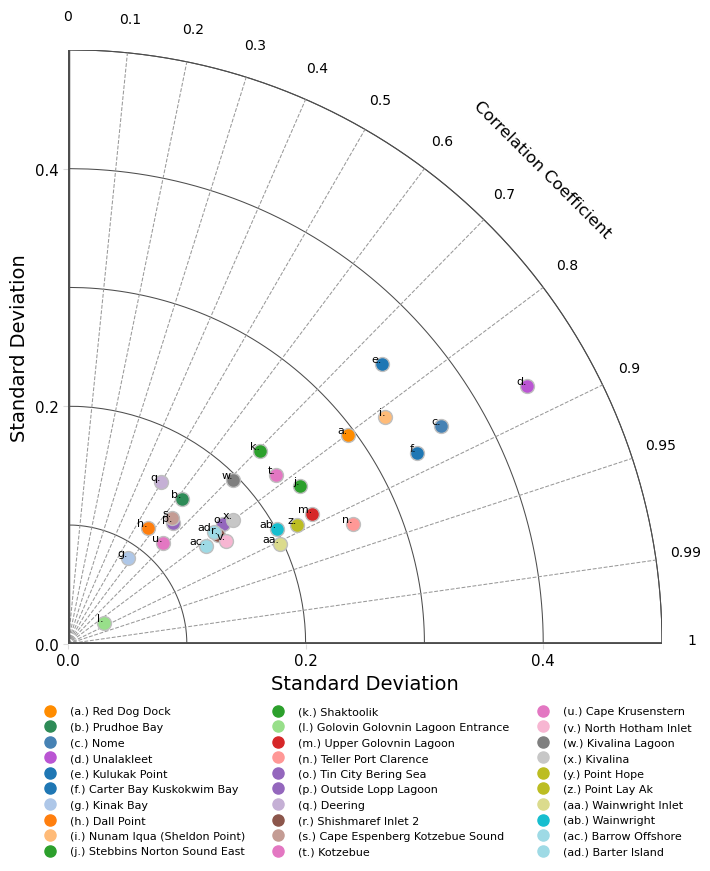

In [29]:

# --- COLOR SETUP ---
#station_labels = [lab for lab, df in stations]

# 3) Find which labels still need colors
#rest = [lab for lab in station_labels if lab not in operational_colors]
labels = [lab for lab, _ in plot_stations]
rest   = [lab for lab in labels if lab not in operational_colors]
cmap   = plt.get_cmap("tab20", len(rest))
# 4) Grab a colormap with enough entries for the “rest”
#cmap = plt.get_cmap('tab20', len(rest))

# 5) Build a complete color_map
color_map = operational_colors.copy()
for i, lab in enumerate(rest):
    # convert to hex so everything is consistent
    color_map[lab] = mcolors.to_hex(cmap(i))

# 6) Now build your final colors list in station order
#colors = [color_map[lab] for lab in station_labels]
# --- TAYLOR DIAGRAM with skill_metrics call only ---
fig_td = plt.figure(figsize=(6,6))
ax_td = plt.axes([0.0,0.,0.99,0.99])

tickrms = [0,1.5]
# Draw Taylor diagram with skill_metrics (markers and grid handled internally)
t_stats = sm.taylor_statistics(stations[0][1]['model_max'],stations[0][1]['noaa_max'])
labels = ['obs',stations[0][0][:3]]
names = ['('+letters[0] + ') ' + stations[0][0]]
color_map = operational_colors.copy()

for i, lab in enumerate(rest):
    color_map[lab] = cmap(i)
c2 = color_map[stations[0][0]]
colors2 = [c2]
sm.taylor_diagram(
    ax_td,
    np.asarray(t_stats['sdev']),
    np.asarray(t_stats['crmsd']),
    np.asarray(t_stats['ccoef']),
    markerLabel=['o',letters[0]],
    markercolors= {'face': c2, 'edge': '#bfbfbf'},#colors[0]},
    axismax = 0.5,
    tickSTD = [0,0.1,0.2,0.3,0.4,0.50],#[0.25,0.5,0.75,1.0,1.25,1.5,1.75],
    tickRMS = tickrms,
    #tickCOR = [0.0,0.2,0.4,0.6,0.8,0.9,0.95,1.0],
    markersize = 20,
    markersymbol = ".",
    titleSTD = 'off',
    titleRMS = 'off',
    showlabelsRMS = 'off',
    rmsLabelFormat='0:.2f',
    colRMS = STYLES_RMS['color'],
    styleRMS = STYLES_RMS['linestyle'],
    colscor = COLS_COR,
    colsstd = COLS_STD,
    widthRMS=0.75,
    widthSTD=0.750,
    widthCOR=0.75,
    styleCOR='--',
    styleSTD='-',
    colframe='#4d4d4d',
    labelweight='normal',
    titlecorshape='linear',)
c = 1
for i in range(1,len(stations)):
    t_stats = sm.taylor_statistics(stations[i][1]['model_max'],stations[i][1]['noaa_max'])
    if np.isnan(t_stats['sdev'][1]) and (stations[i][0] not in labels):
        pass
    else:
        names.append('('+letters[c] + ') ' + stations[i][0])
        labels = ['obs',letters[c]]
        c2 = color_map[stations[i][0]]
        colors2.append(c2)
        sm.taylor_diagram(
            ax_td,
            np.asarray(t_stats['sdev']),
            np.asarray(t_stats['crmsd']),
            np.asarray(t_stats['ccoef']),
            markerLabel=labels,
            markercolors= {'face': c2, 'edge': '#bfbfbf'},#colors[c]},
            markersize = 20,
            markersymbol = ".",
            overlay = 'on',
            styleCOR='--',
            styleSTD='-',
            titlecorshape='linear',)

        c +=1 
ax_td.set_xlabel('Standard Deviation',fontsize=14),ax_td.set_ylabel('Standard Deviation',fontsize=14)
# Build legend
legend_handles = [plt.Line2D([], [], color=colors2[i], marker='o', linestyle='None', markersize=8, label=names[i])
                  for i, lab in enumerate(names)]
plt.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.375), ncol=3, frameon=False,fontsize=8)

plt.savefig(fig_dir / 'taylor_custom.png', dpi=750, bbox_inches='tight')
plt.show()

In [32]:
name = 'nome'
df_noaa_daily = pd.read_csv(f'/scratch/tmiesse/project/noaa_data/{name}_mhhw.csv')
df_hourly_wse = pd.read_csv(f'/scratch/tmiesse/project/model_data/{name}_model_hourly_wse.csv')
df_hourly_wse["dt"] = pd.to_datetime(df_hourly_wse["dt"], errors="coerce")
df_hourly_wse["data"] = pd.to_numeric(df_hourly_wse["data"], errors="coerce")
df_hourly_wse = df_hourly_wse.dropna(subset=["dt", "data"]).copy()

# Extract the daily max WSE with exact timestamp preserved
df_model_daily = (
    df_hourly_wse
    .set_index("dt")
    .resample("D")["data"]
    .max()
    .reset_index()
)
years = ['2024','2023','2022','2021','2020','2019',
         '2018','2017','2016','2015','2014','2013',
         '2012','2011','2010']

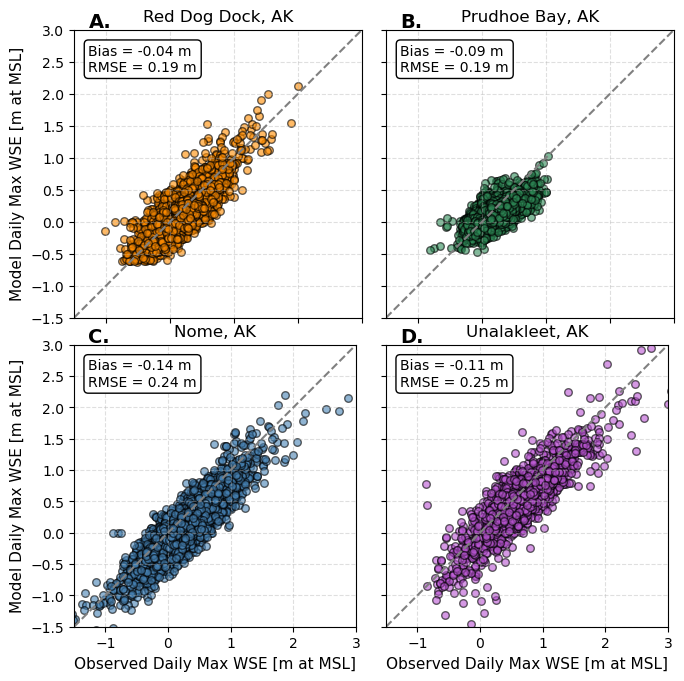

In [5]:
def rmse(x, y):
    return np.sqrt(np.mean((x - y) ** 2))

# Define your stations and colors
stations = {
    "red": "darkorange",       # top-left
    "prudhoe": "seagreen",        # top-right
    "nome": "steelblue",          # bottom-left
    "unalakleet": "mediumorchid"  # bottom-right
}
# Create manual axes for precise layout
fig = plt.figure(figsize=(6, 6))
ax = [
    plt.axes([0, 0.52, 0.48, 0.48]),    # top-left
    plt.axes([0.52, 0.52, 0.48, 0.48]), # top-right
    plt.axes([0, 0.0, 0.47, 0.48]),     # bottom-left
    plt.axes([0.52, 0.0, 0.47, 0.48])   # bottom-right
]
labels = ['A.', 'B.', 'C.', 'D.']
lims = [-1.5, 3]

for i, (name, color) in enumerate(stations.items()):
    # Load NOAA
    df_noaa = pd.read_csv(f'/scratch/tmiesse/project/noaa_data/{name}_mhhw.csv')
    df_noaa["Date"] = pd.to_datetime(df_noaa["Date"], errors="coerce")
    df_noaa["v"] = pd.to_numeric(df_noaa["v"], errors="coerce")
    df_noaa_clean = df_noaa.dropna(subset=["Date", "v"])

    df_noaa_daily_exact = (
        df_noaa_clean
        .groupby(df_noaa_clean["Date"].dt.date)
        .apply(lambda x: x.loc[x["v"].idxmax()])
        .reset_index(drop=True)
        .rename(columns={"Date": "dt", "v": "NOAA Max WSE"})
    )

    # Load Model
    df_hourly = pd.read_csv(f'/scratch/tmiesse/project/model_data/{name}_model_hourly_wse.csv')
    df_hourly["dt"] = pd.to_datetime(df_hourly["dt"], errors="coerce")
    df_hourly["data"] = pd.to_numeric(df_hourly["data"], errors="coerce")
    df_hourly = df_hourly.dropna(subset=["dt", "data"])

    df_model_daily = (
        df_hourly
        .set_index("dt")
        .resample("D")["data"]
        .max()
        .reset_index()
    )

    df_model_daily_exact = (
        df_model_daily
        .dropna()
        .groupby(df_model_daily["dt"].dt.date)
        .apply(lambda x: x.loc[x["data"].idxmax()])
        .reset_index(drop=True)
    )

    df_model_daily_exact["dt"] = pd.to_datetime(df_model_daily_exact["dt"], utc=True)
    df_noaa_daily_exact["dt"] = pd.to_datetime(df_noaa_daily_exact["dt"], utc=True)

    # Merge and compare
    df_compare = pd.merge(df_model_daily_exact, df_noaa_daily_exact, on="dt", how="inner").dropna()

    # --- Plotting ---
    a = ax[i]
    a.scatter(df_compare["NOAA Max WSE"], df_compare["data"],
              color=color, edgecolor="k", alpha=0.6, s=30)
    a.plot(lims, lims, "--", color="gray")

    # Stats
    rmse_val = rmse(df_compare["NOAA Max WSE"], df_compare["data"])
    mbias = np.mean(df_compare["data"] - df_compare["NOAA Max WSE"])
    text = f'Bias = {mbias:.2f} m\nRMSE = {rmse_val:.2f} m'
    a.text(0.05, 0.95, text, transform=a.transAxes, fontsize=10,
           verticalalignment='top', bbox=dict(boxstyle='round', fc='white', ec='black'))

    a.set_xlim(lims)
    a.set_ylim(lims)
    a.set_aspect("equal")
    a.grid(True, linestyle="--", alpha=0.4)
    a.text(0.05, 1.06, labels[i], transform=a.transAxes,
           fontsize=14, fontweight='bold', va='top', ha='left')
    if name == 'red':
        a.set_title(f"Red Dog Dock, AK", fontsize=12)
    if name == 'prudhoe':
        a.set_title(f"Prudhoe Bay, AK", fontsize=12)
    if name == 'nome':
        a.set_title(f"Nome, AK", fontsize=12)
    if name == 'unalakleet':
        a.set_title(f"Unalakleet, AK", fontsize=12)
    if i in [2, 3]:
        a.set_xlabel("Observed Daily Max WSE [m at MSL]", fontsize=11)
    if i in [0, 2]:
        a.set_ylabel("Model Daily Max WSE [m at MSL]", fontsize=11)

    # Hide yticks for right-side subplots
    if i in [1, 3]:
        a.set_yticklabels([])
    # Hide xticks for top subplots
    if i in [0, 1]:
        a.set_xticklabels([])

plt.savefig(f'/scratch/tmiesse/project/figures/daily_final_scatter.png', 
            dpi=720, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.show()

/tmp/ipykernel_1717799/1525557684.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


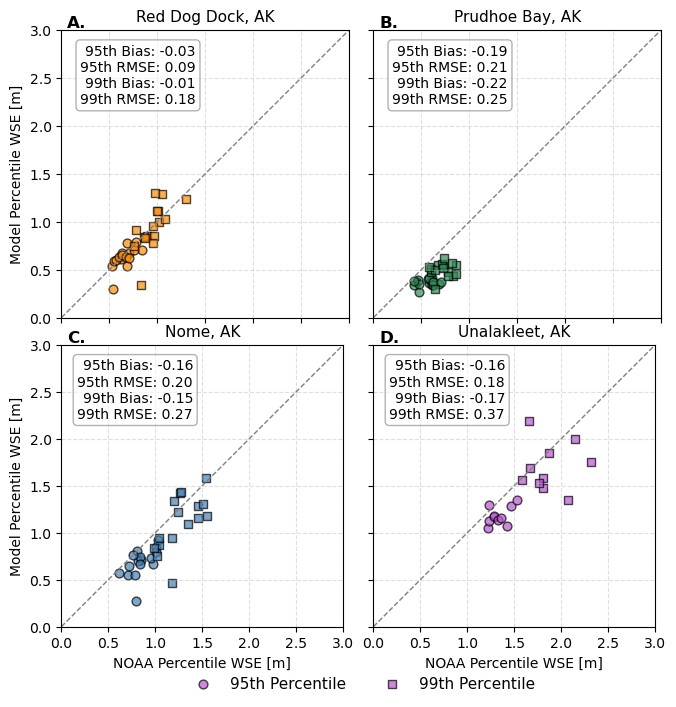

In [23]:
fig = plt.figure(figsize=(6, 6))
ax = [
    plt.axes([0, 0.52, 0.48, 0.48]),    # top-left
    plt.axes([0.52, 0.52, 0.48, 0.48]), # top-right
    plt.axes([0, 0.0, 0.47, 0.48]),     # bottom-left
    plt.axes([0.52, 0.0, 0.47, 0.48])   # bottom-right
]
stations = {
    "red": {"name": "Red Dog Dock, AK", "color": "darkorange"},
    "prudhoe": {"name": "Prudhoe Bay, AK", "color": "seagreen"},
    "nome": {"name": "Nome, AK", "color": "steelblue"},
    "unalakleet": {"name": "Unalakleet, AK", "color": "mediumorchid"},
}

subplot_labels = ['A.', 'B.', 'C.', 'D.']

for i, (name, meta) in enumerate(stations.items()):
    station_name = meta["name"]
    color = meta["color"]
    axx = ax[i]

    df_noaa = pd.read_csv(f"/scratch/tmiesse/project/noaa_data/{name}_mhhw.csv")
    df_model = pd.read_csv(f"/scratch/tmiesse/project/model_data/{name}_model_hourly_wse.csv")

    df_model["dt"] = pd.to_datetime(df_model["dt"], errors="coerce")
    df_model["data"] = pd.to_numeric(df_model["data"], errors="coerce")
    df_model = df_model.dropna(subset=["dt", "data"]).copy()
    df_model_daily = df_model.set_index("dt").resample("D")["data"].max().reset_index()

    df_noaa["Date"] = pd.to_datetime(df_noaa["Date"], errors="coerce")
    df_model_daily["Year"] = df_model_daily["dt"].dt.year
    df_noaa["Year"] = df_noaa["Date"].dt.year

    df_model_percentiles = (
        df_model_daily.groupby("Year")["data"]
        .quantile([0.95, 0.99])
        .unstack()
        .reset_index()
        .rename(columns={0.95: "Model 95th", 0.99: "Model 99th"})
    )
    df_noaa_percentiles = (
        df_noaa.groupby("Year")["v"]
        .quantile([0.95, 0.99])
        .unstack()
        .reset_index()
        .rename(columns={0.95: "NOAA 95th", 0.99: "NOAA 99th"})
    )

    df_compare = pd.merge(df_model_percentiles, df_noaa_percentiles, on="Year", how="inner")

    scatter_95 = axx.scatter(df_compare["NOAA 95th"], df_compare["Model 95th"],
                             label="95th Percentile", color=color, edgecolor="k", s=40, alpha=0.7)
    scatter_99 = axx.scatter(df_compare["NOAA 99th"], df_compare["Model 99th"],
                             label="99th Percentile", color=color, edgecolor="k", s=40, marker="s", alpha=0.7)

    axx.plot([0, 3], [0, 3], "--", color="gray", linewidth=1)
    axx.set_xlim([0, 3])
    axx.set_ylim([0, 3])
    axx.set_aspect("equal")
    axx.grid(True, linestyle="--", alpha=0.4)
    axx.set_title(f"{station_name}", fontsize=11)

    if i in [0, 2]:
        axx.set_ylabel("Model Percentile WSE [m]", fontsize=10)
    else:
        axx.set_yticklabels([])

    if i in [2, 3]:
        axx.set_xlabel("NOAA Percentile WSE [m]", fontsize=10)
    else:
        axx.set_xticklabels([])

    rmse_95 = rmse(df_compare["Model 95th"], df_compare["NOAA 95th"])
    bias_95 = np.mean(df_compare["Model 95th"] - df_compare["NOAA 95th"])
    rmse_99 = rmse(df_compare["Model 99th"], df_compare["NOAA 99th"])
    bias_99 = np.mean(df_compare["Model 99th"] - df_compare["NOAA 99th"])
    stat = f"95th Bias: {bias_95:.2f}\n95th RMSE: {rmse_95:.2f}\n99th Bias: {bias_99:.2f}\n99th RMSE: {rmse_99:.2f}"
    axx.text(1.40, 2.85, stat, fontsize=10, va="top", ha="right",
             bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.6))

    # Add subplot label
    axx.text(0.02, 1.05, f"{subplot_labels[i]}", transform=axx.transAxes,
             fontsize=12, fontweight="bold", va="top", ha="left")

# Add legend in a blank spot below all plots
fig.legend(
    handles=[scatter_95, scatter_99],
    labels=["95th Percentile", "99th Percentile"],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.125),  # move it lower
    ncol=2,
    frameon=False,
    fontsize=11
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.savefig(f'/scratch/tmiesse/project/figures/percentile_final_scatter.png', 
            dpi=720, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.show()

/tmp/ipykernel_1717799/1328028890.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x["data"].idxmax()])
/tmp/ipykernel_1717799/1328028890.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x["v"].idxmax()])
/tmp/ipykernel_1717799/1328028890.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and 

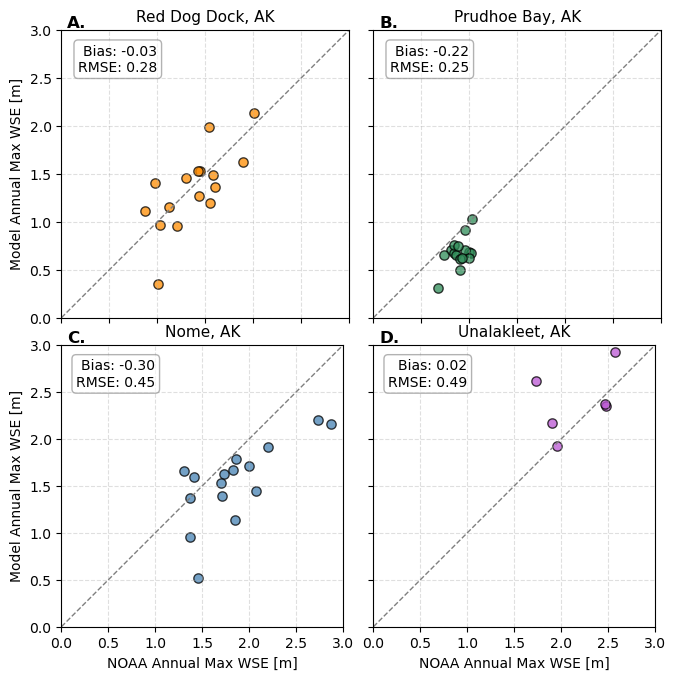

In [29]:
fig = plt.figure(figsize=(6, 6))
ax = [
    plt.axes([0, 0.52, 0.48, 0.48]),    # top-left
    plt.axes([0.52, 0.52, 0.48, 0.48]), # top-right
    plt.axes([0, 0.0, 0.47, 0.48]),     # bottom-left
    plt.axes([0.52, 0.0, 0.47, 0.48])   # bottom-right
]
stations = {
    "red": {"name": "Red Dog Dock, AK", "color": "darkorange"},
    "prudhoe": {"name": "Prudhoe Bay, AK", "color": "seagreen"},
    "nome": {"name": "Nome, AK", "color": "steelblue"},
    "unalakleet": {"name": "Unalakleet, AK", "color": "mediumorchid"},
}

subplot_labels = ['A.', 'B.', 'C.', 'D.']

for i, (name, meta) in enumerate(stations.items()):
    station_name = meta["name"]
    color = meta["color"]
    axx = ax[i]

    df_noaa = pd.read_csv(f"/scratch/tmiesse/project/noaa_data/{name}_mhhw.csv")
    df_model = pd.read_csv(f"/scratch/tmiesse/project/model_data/{name}_model_hourly_wse.csv")

    df_model["dt"] = pd.to_datetime(df_model["dt"], errors="coerce")
    df_model["data"] = pd.to_numeric(df_model["data"], errors="coerce")
    df_model = df_model.dropna(subset=["dt", "data"]).copy()
    df_model["Year"] = df_model["dt"].dt.year
    df_model["Date"] = df_model["dt"].dt.date

    df_model_max = (
        df_model.groupby("Year")
        .apply(lambda x: x.loc[x["data"].idxmax()])
        .reset_index(drop=True)
        .rename(columns={"data": "Model Max", "dt": "dt_model"})
    )

    df_noaa["Date"] = pd.to_datetime(df_noaa["Date"], errors="coerce")
    df_noaa["v"] = pd.to_numeric(df_noaa["v"], errors="coerce")
    df_noaa = df_noaa.dropna(subset=["Date", "v"]).copy()
    df_noaa["Year"] = df_noaa["Date"].dt.year

    df_noaa_max = (
        df_noaa.groupby("Year")
        .apply(lambda x: x.loc[x["v"].idxmax()])
        .reset_index(drop=True)
        .rename(columns={"v": "NOAA Max"})
    )

    df_compare = pd.merge(
        df_model_max[["Year", "Model Max"]],
        df_noaa_max[["Year", "NOAA Max"]],
        on="Year",
        how="inner"
    )

    scatter = axx.scatter(df_compare["NOAA Max"], df_compare["Model Max"],
                          color=color, edgecolor="k", s=45, alpha=0.75)

    axx.plot([0, 3], [0, 3], "--", color="gray", linewidth=1)
    axx.set_xlim([0, 3])
    axx.set_ylim([0, 3])
    axx.set_aspect("equal")
    axx.grid(True, linestyle="--", alpha=0.4)
    axx.set_title(f"{station_name}", fontsize=11)

    if i in [0, 2]:
        axx.set_ylabel("Model Annual Max WSE [m]", fontsize=10)
    else:
        axx.set_yticklabels([])

    if i in [2, 3]:
        axx.set_xlabel("NOAA Annual Max WSE [m]", fontsize=10)
    else:
        axx.set_xticklabels([])

    rmse_val = rmse(df_compare["Model Max"], df_compare["NOAA Max"])
    bias = np.mean(df_compare["Model Max"] - df_compare["NOAA Max"])
    stat = f"Bias: {bias:.2f}\nRMSE: {rmse_val:.2f}"
    axx.text(1.0, 2.85, stat, fontsize=10, va="top", ha="right",
             bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.6))

    # Add subplot label
    axx.text(0.02, 1.05, f"{subplot_labels[i]}", transform=axx.transAxes,
             fontsize=12, fontweight="bold", va="top", ha="left")

# Legend

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig(f'/scratch/tmiesse/project/figures/annual_final_scatter.png', 
            dpi=720, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.show()

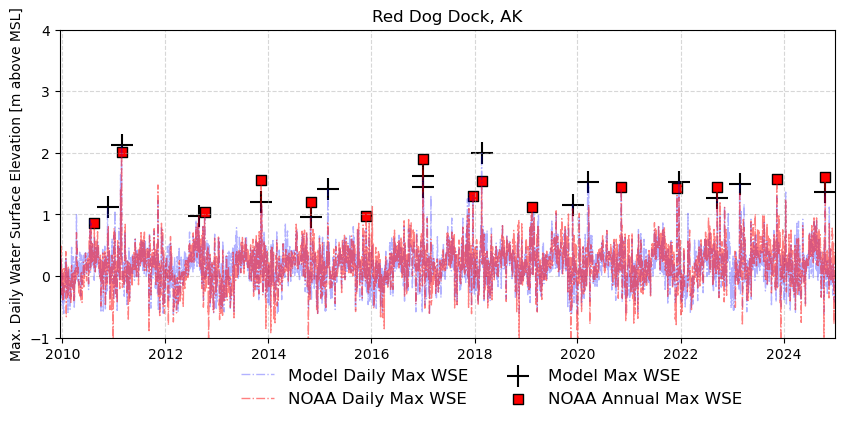

In [10]:

df_model_daily["Date"] = pd.to_datetime(df_model_daily["dt"]).dt.date  # Convert to date
df_model_daily["Date"] = pd.to_datetime(df_model_daily["Date"])  # Ensure it's in datetime64
df_model_daily = df_model_daily.sort_values(by="Date").reset_index(drop=True)
df_noaa_daily["Date"] = pd.to_datetime(df_noaa_daily["Date"]) 
df_noaa_daily["Year"] = pd.to_datetime(df_noaa_daily["Date"]).dt.year

fig, ax = plt.subplots(figsize=(10, 4))
# Plot Model Daily Max WSE
ax.plot(pd.to_datetime(df_model_daily["Date"]), df_model_daily["data"], linestyle='-.',lw=1,
        color="blue", alpha=0.3, label="Model Daily Max WSE")# if year == int(years[0]) else "")

# Plot NOAA Daily Max WSE
ax.plot(pd.to_datetime(df_noaa_daily["Date"]), df_noaa_daily["v"], linestyle='-.',lw=1,
        color="red", alpha=0.5, label="NOAA Daily Max WSE")# if year == int(years[0]) else "")

for year in years:
    # **Model Annual Max Extraction**
    idy_model = df_model_daily.loc[df_model_daily['Date'].dt.year == int(year)]
    if not idy_model.empty:
        ids_model = np.where(df_model_daily['data'].values == np.max(df_model_daily['data'][idy_model.index]))[0]
        ax.scatter(df_model_daily["Date"][ids_model], df_model_daily["data"][ids_model], 
                   color="k", marker="+", s=250, label="Model Max WSE" if year == years[0] else "")

    # **NOAA Annual Max Extraction**
    idy_noaa = df_noaa_daily.loc[df_noaa_daily['Date'].dt.year == int(year)]
    if not idy_noaa.empty:
        ids_noaa = np.where(df_noaa_daily['v'].values == np.max(df_noaa_daily['v'][idy_noaa.index]))[0]
        ax.scatter(df_noaa_daily["Date"][ids_noaa], df_noaa_daily["v"][ids_noaa], 
                   color="red", marker="s", s=50, label="NOAA Annual Max WSE" if year == years[0] else "", edgecolors="black")

ax.set_ylabel("Max. Daily Water Surface Elevation [m above MSL]")
ax.set_ylim([-1,4])
ax.set_xlim([pd.to_datetime(df_model_daily["Date"].min()), pd.to_datetime(df_model_daily["Date"].max())])
ax.set_title(f"{name.capitalize()} Dog Dock, AK")#{name.capitalize()},
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend(loc='upper right', bbox_to_anchor=(.9, -0.05), ncol=2, frameon=False, fontsize=12)
plt.savefig(f'/scratch/tmiesse/project/figures/{name}_daily_max_model_vs_noaa_scatter.png', 
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)

plt.show()

In [3]:
gdf = gpd.read_file("/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database/arctic_shapefiles/comm_and_flood/community+flood_wgs.shp")
gdf["flood_MSL"] = pd.to_numeric(gdf["flood_MSL"], errors="coerce")
gdf["CommunityKey"] = gdf["CommunityN"].str.strip().str.lower()
gdf["Date"] = pd.to_datetime(gdf["Date"], errors="coerce")
gdf = gdf[gdf["flood_MSL"] > 0]


# Load node locations once
with nc4.Dataset(root / '2024' / 'outputs' /"fort.63.nc") as sample_nc:
    node_lons = sample_nc.variables["x"][:]
    node_lats = sample_nc.variables["y"][:]
    node_points = gpd.GeoSeries([Point(lon, lat) for lon, lat in zip(node_lons, node_lats)], crs="EPSG:4326")

# Pre-map: Community -> node indices inside polygon
community_nodes = {}
for idx, row in gdf.iterrows():
    poly = row.geometry
    name_lc = row["CommunityKey"]
    mask = node_points.within(poly)
    node_indices = np.where(mask)[0]
    if len(node_indices) > 0:
        community_nodes[name_lc] = node_indices

/tmp/ipykernel_4078700/368369691.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gdf["Date"] = pd.to_datetime(gdf["Date"], errors="coerce")


In [ ]:


# --- Step 1: Pre-filter communities that have a historic event in given years ---
years = ['2024','2023','2022','2021','2020','2019',
         '2018','2017','2016','2015','2013','2012',
         '2011','2010','2009','2008','2007','2006',
         '2005','2004','2003','2002','2001','2000','1999']

# Build a DataFrame from shapefile first
historic_comparisons = []

for year in years:
    print(f"Processing {year}...")
    ncfile = nc4.Dataset(root / year / "outputs" / "fort.63.nc")
    ref_time = pd.to_datetime(ncfile.variables["time"].base_date)
    dt = pd.date_range(start=ref_time, periods=ncfile.dimensions["time"].size, freq="1h")

    # Filter shapefile by historical event year
    gdf_year = gdf[gdf["Date"].dt.year == int(year)]

    for _, row in gdf_year.iterrows():
        name_lc = row["CommunityKey"]
        historic_date = row["Date"]
        flood_msl = row["flood_MSL"]

        if name_lc not in community_nodes:
            continue

        node_idxs = community_nodes[name_lc]
        max_val = -np.inf
        max_time = None

        for node in node_idxs:
            wse = ncfile.variables["zeta"][:, node]
            wse = np.where(wse == -9999, np.nan, wse)

            mask = pd.to_datetime(dt).date == historic_date.date()
            if np.any(mask):
                wse_day = wse[mask]
                if np.nanmax(wse_day) > max_val:
                    max_val = np.nanmax(wse_day)
                    max_time = dt[mask][np.nanargmax(wse_day)]

        if np.isfinite(max_val):
            historic_comparisons.append({
                "Community": name_lc.title(),
                "Historic_Date": historic_date.date(),
                "Flood_Stage_Historic": flood_msl,
                "Model_WSE_Historic": max_val,
                "Model_Timestamp": max_time,
                "Year_Model_Data": int(year)
            })

    ncfile.close()

# Save output
df_out = pd.DataFrame(historic_comparisons)
df_out.to_csv("/scratch/tmiesse/project/model_data/historic_flood_comparison.csv", index=False)


Processing 2024...
Processing 2023...
Processing 2022...
Processing 2021...
Processing 2020...
Processing 2019...
Processing 2018...
Processing 2017...
Processing 2016...
Processing 2015...
Processing 2013...


In [22]:
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions - targets)**2))

In [17]:
df_noaa = df_noaa_daily.copy()
df_noaa["t"] = pd.to_datetime(df_noaa["Date"])
df_noaa["Date"] = pd.to_datetime(df_noaa["Date"], errors="coerce")
df_noaa["v"] = pd.to_numeric(df_noaa["v"], errors="coerce")
df_noaa_clean = df_noaa.dropna(subset=["t", "v"]).copy()
df_noaa_clean["date"] = df_noaa_clean["t"].dt.date

daily_max_values = df_noaa_clean.groupby("date")["v"].max().reset_index()
daily_max_values.rename(columns={"v": "NOAA Max WSE"}, inplace=True)
df_noaa = df_noaa_daily.copy()
df_noaa["t"] = pd.to_datetime(df_noaa["Date"])
df_noaa["v"] = pd.to_numeric(df_noaa["v"], errors="coerce")
df_noaa = df_noaa.dropna(subset=["v"])

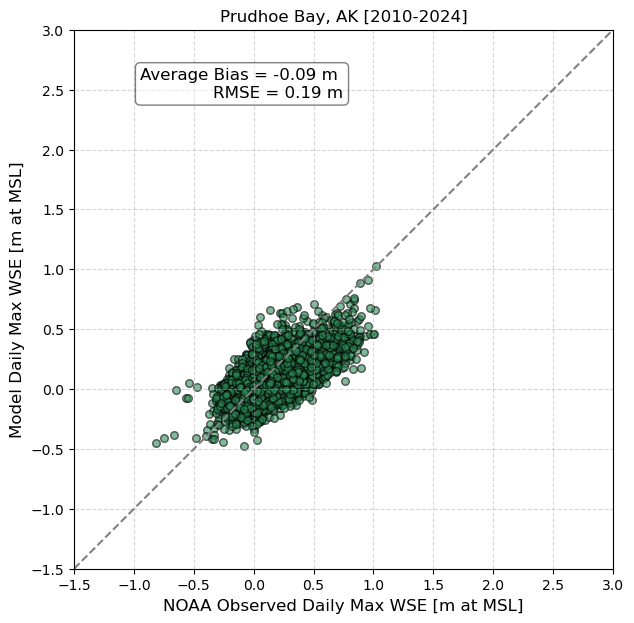

In [18]:
df_noaa["Date"] = pd.to_datetime(df_noaa["Date"], errors="coerce")
df_noaa_daily_exact = (
    df_noaa
    .groupby(df_noaa["Date"].dt.date)
    .apply(lambda x: x.loc[x["v"].idxmax()])
    .reset_index(drop=True)
    .rename(columns={"Date": "dt", "v": "NOAA Max WSE"})
)

# Model: same idea — max per day with exact datetime preserved
#df_model_daily["dt"] = pd.to_datetime(df_model_daily["dt"], errors="coerce")
#df_model_daily["data"] = pd.to_numeric(df_model_daily["data"], errors="coerce")

# Drop rows where model WSE is missing
df_model_daily_clean = df_model_daily.dropna(subset=["dt", "data"]).copy()

# Now safely extract the daily max values with exact timestamps
df_model_daily_exact = (
    df_model_daily_clean
    .groupby(df_model_daily_clean["dt"].dt.date)
    .apply(lambda x: x.loc[x["data"].idxmax()])
    .reset_index(drop=True)
)
df_model_daily_exact["dt"] = pd.to_datetime(df_model_daily_exact["dt"], utc=True)
df_noaa_daily_exact["dt"] = pd.to_datetime(df_noaa_daily_exact["dt"], utc=True)
# Step 2: Merge on exact matching UTC datetimes
df_compare_exact = pd.merge(df_model_daily, df_noaa_daily_exact, on="dt", how="inner").dropna()
# --- Step 4: Create scatter plot with 1:1 line only ---
fig, ax = plt.subplots(figsize=(7, 7))

# steelblue nome
# darkorange red dog
# seagreen prudhoe 
# mediumorchid unalakleet

# Scatter plot
color = "seagreen"
ax.scatter(df_compare_exact["NOAA Max WSE"], df_compare_exact["data"],
           color=color, edgecolor="k", alpha=0.6, s=30) 
rmse_val = rmse(df_compare_exact["NOAA Max WSE"], df_compare_exact["data"])
mbias = np.mean(df_compare_exact["data"]-df_compare_exact["NOAA Max WSE"])
text = (f'Average Bias = {mbias:.2f} m \n'
        f'RMSE = {rmse_val:.2f} m')
bbox = dict(boxstyle='round', fc='white', ec='black', alpha=0.5)
ax.text(0.5,0.875,text,fontsize=12,transform=ax.transAxes, horizontalalignment='right',bbox=bbox)

lims = [-1.5, 3]
ax.plot(lims, lims, linestyle="--", color="gray")

# Labels and formatting
ax.set_xlabel("NOAA Observed Daily Max WSE [m at MSL]",fontsize=12)
ax.set_ylabel("Model Daily Max WSE [m at MSL]",fontsize=12)
ax.set_title(f"{name.capitalize()} Bay, AK [2010-2024]")
ax.set_xlim(lims),ax.set_ylim(lims)
ax.set_aspect('equal'),ax.grid(True, linestyle="--", alpha=0.5)
#plt.savefig(f'/scratch/tmiesse/project/figures/{name}_scatter2.png', 
#            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.show()

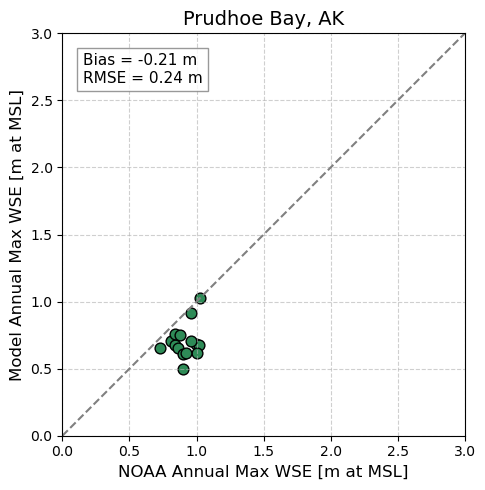

In [19]:
df_model_daily["Year"] = df_model_daily["dt"].dt.year
df_noaa_daily["Year"] = pd.to_datetime(df_noaa_daily["Date"]).dt.year
model_year_counts = df_model_daily["dt"].dt.date.groupby(df_model_daily["Year"]).nunique()
valid_model_years = model_year_counts[model_year_counts >= 364].index.tolist()

# Keep only complete years in model data
df_model_daily = df_model_daily[df_model_daily["Year"].isin(valid_model_years)]

# Optional: log dropped years
all_model_years = df_model_daily["Year"].unique()
excluded_years = set(model_year_counts.index) - set(valid_model_years)

model_annual_max = df_model_daily.groupby("Year")["data"].max().reset_index()
model_annual_max.rename(columns={"data": "Model Max WSE"}, inplace=True)

noaa_annual_max = df_noaa_daily.groupby("Year")["v"].max().reset_index()
noaa_annual_max.rename(columns={"v": "NOAA Max WSE"}, inplace=True)

# --- Step 4: Keep only years present in both datasets ---
common_years = sorted(set(model_annual_max["Year"]).intersection(noaa_annual_max["Year"]))
model_annual_max = model_annual_max[model_annual_max["Year"].isin(common_years)]
noaa_annual_max = noaa_annual_max[noaa_annual_max["Year"].isin(common_years)]

# --- Step 5: Merge the two datasets ---
df_annual_compare = pd.merge(model_annual_max, noaa_annual_max, on="Year", how="inner")


# --- Step 4: Optional error metrics ---
rmse_val = rmse(df_annual_compare["NOAA Max WSE"], df_annual_compare["Model Max WSE"])
bias_val = (df_annual_compare["Model Max WSE"] - df_annual_compare["NOAA Max WSE"]).mean()

# --- Step 5: Scatter Plot ---
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(df_annual_compare["NOAA Max WSE"], df_annual_compare["Model Max WSE"],
           color=color, edgecolor="black", s=60)

# 1:1 line
lims = [0,3]
ax.plot(lims, lims, linestyle="--", color="gray")

# Labels and stats
ax.set_xlabel("NOAA Annual Max WSE [m at MSL]", fontsize=12)
ax.set_ylabel("Model Annual Max WSE [m at MSL]", fontsize=12)
ax.set_title(f"{name.capitalize()} Bay, AK", fontsize=14)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect("equal")
ax.grid(True, linestyle="--", alpha=0.6)

# Annotate metrics
ax.text(0.05, 0.95,
        f"Bias = {bias_val:.2f} m\nRMSE = {rmse_val:.2f} m",
        transform=ax.transAxes, fontsize=11,
        bbox=dict(facecolor="white", edgecolor="gray", alpha=0.8),
        verticalalignment="top")

plt.tight_layout()
plt.savefig(f"/scratch/tmiesse/project/figures/{name}_annual_max_scatter.png", 
            dpi=480, bbox_inches="tight", pad_inches=0.1, transparent=False)
plt.show()

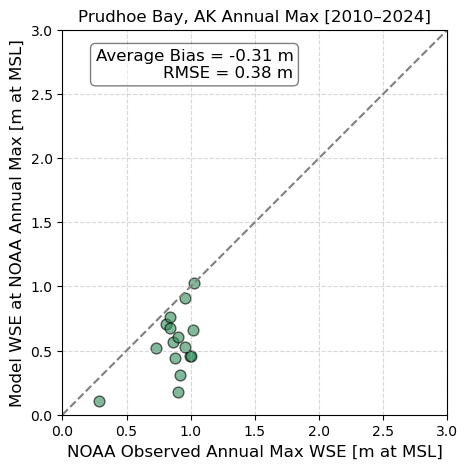

In [20]:
df_noaa_annual = df_compare_exact.loc[
    df_compare_exact.groupby(df_compare_exact["dt"].dt.year)["NOAA Max WSE"].idxmax()
].copy()

# Step 2: Extract matching model value at the same datetime (already present in df_compare_exact)
# This step is already implicitly done since df_compare_exact holds model and NOAA at same timestamp
# So we already have NOAA annual max AND corresponding model value

# Step 3: Plot the result
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(df_noaa_annual["NOAA Max WSE"], df_noaa_annual["data"],
           color=color, edgecolor="k", alpha=0.6, s=60)

# Error metrics
rmse_val = rmse(df_noaa_annual["NOAA Max WSE"], df_noaa_annual["data"])
mbias = (df_noaa_annual["data"] - df_noaa_annual["NOAA Max WSE"]).mean()

text = f"Average Bias = {mbias:.2f} m\nRMSE = {rmse_val:.2f} m"
bbox = dict(boxstyle='round', fc='white', ec='black', alpha=0.5)

ax.text(0.6, 0.875, text, fontsize=12, transform=ax.transAxes,
        horizontalalignment='right', bbox=bbox)

# 1:1 reference line
lims = [0, 3]
ax.plot(lims, lims, linestyle="--", color="gray")

# Labels and formatting
ax.set_xlabel("NOAA Observed Annual Max WSE [m at MSL]", fontsize=12)
ax.set_ylabel("Model WSE at NOAA Annual Max [m at MSL]", fontsize=12)
ax.set_title(f"{name.capitalize()} Bay, AK Annual Max [2010–2024]")
ax.set_xlim(lims), ax.set_ylim(lims)
ax.set_aspect('equal'), ax.grid(True, linestyle="--", alpha=0.5)

# Save and show
plt.savefig(f'/scratch/tmiesse/project/figures/{name}_annual_max_aligned_scatter.png',
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.show()

In [33]:
df_model_daily["Year"] = pd.to_datetime(df_model_daily["dt"]).dt.year
df_noaa_daily["Year"] = pd.to_datetime(df_noaa_daily["Date"]).dt.year
df_model_percentiles = (
    df_model_daily.groupby("Year")["data"]
    .quantile([0.95, 0.99])
    .unstack()
    .reset_index()
    .rename(columns={0.95: "Model 95th", 0.99: "Model 99th"})
)

# NOAA percentiles
df_noaa_percentiles = (
    df_noaa_daily.groupby("Year")["v"]
    .quantile([0.95, 0.99])
    .unstack()
    .reset_index()
    .rename(columns={0.95: "NOAA 95th", 0.99: "NOAA 99th"})
)
df_compare_percentiles = pd.merge(
    df_model_percentiles,
    df_noaa_percentiles,
    on="Year",
    how="inner"
)

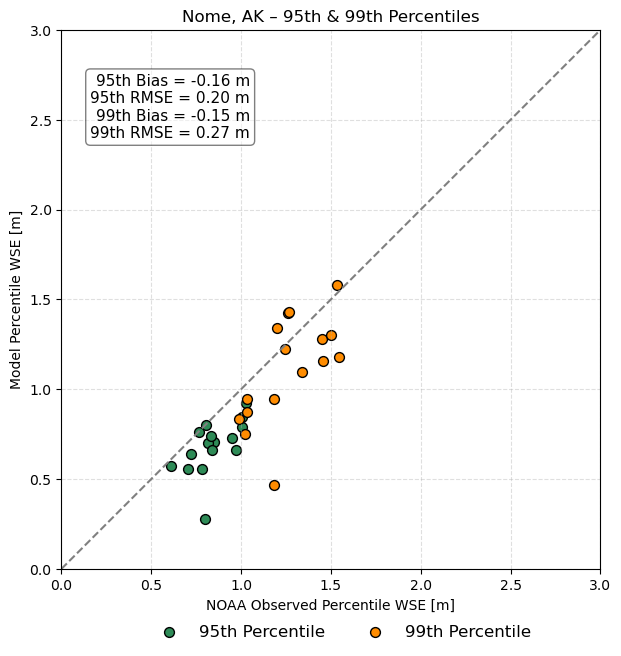

In [35]:

fig, ax = plt.subplots(figsize=(7, 7))

# Scatter for 95th
ax.scatter(df_compare_percentiles["NOAA 95th"], df_compare_percentiles["Model 95th"],
           label="95th Percentile", color="seagreen", edgecolor="k", s=50)

# Scatter for 99th
ax.scatter(df_compare_percentiles["NOAA 99th"], df_compare_percentiles["Model 99th"],
           label="99th Percentile", color="darkorange", edgecolor="k", s=50)

# 1:1 line
lims = [0, 3]
ax.plot(lims, lims, "--", color="gray")
rmse_95 = rmse(df_compare_percentiles["Model 95th"], df_compare_percentiles["NOAA 95th"])
bias_95 = np.mean(df_compare_percentiles["Model 95th"] - df_compare_percentiles["NOAA 95th"])

# 99th Percentile Comparison
rmse_99 = rmse(df_compare_percentiles["Model 99th"], df_compare_percentiles["NOAA 99th"])
bias_99 = np.mean(df_compare_percentiles["Model 99th"] - df_compare_percentiles["NOAA 99th"])
text = (
    f"95th Bias = {bias_95:.2f} m\n"
    f"95th RMSE = {rmse_95:.2f} m\n"
    f"99th Bias = {bias_99:.2f} m\n"
    f"99th RMSE = {rmse_99:.2f} m"
)

bbox = dict(boxstyle="round", fc="white", ec="black", alpha=0.5)
ax.text(0.35, 0.8, text, transform=ax.transAxes,
        fontsize=11, ha="right", bbox=bbox)
# Labels and styling
ax.set_xlabel("NOAA Observed Percentile WSE [m]")
ax.set_ylabel("Model Percentile WSE [m]")
ax.set_title(f"{name.capitalize()}, AK – 95th & 99th Percentiles")
ax.set_xlim(lims), ax.set_ylim(lims)
ax.set_aspect("equal"), ax.grid(True, linestyle="--", alpha=0.4)
ax.legend(loc='upper right', bbox_to_anchor=(.9, -0.075), ncol=2, frameon=False, fontsize=12)
plt.savefig(f'/scratch/tmiesse/project/figures/{name}_percentile_scatter.png',
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.show()

### Evaluate Constituents

In [71]:
ncfile = nc4.Dataset(root / '2010' /'outputs' / 'fort.53.nc')
keys = [nc4.chartostring(data).tolist().strip() for data in ncfile.variables['const'][:].data]
stations = {'prudhoe':{'id':9497645,'lat':70.421459,'lon':-148.546311},
            'red':{'id':9491094,'lat':67.578024,'lon':-164.074051},
            'nome':{'id':9468756,'lat':64.499170,'lon':-165.431689},
            'unalakleet':{'id':9468333,'lat':63.881322,'lon':-160.820145},
            'paul':{'id':9464212,'lat':57.228635,'lon':-170.241801}}


In [49]:
station_name = [nc4.chartostring(data).tolist().strip() for data in ncfile.variables['station_name'][:].data]
station_name

['Village Cove, St Paul Island ID:9464212',
 'Unalakleet ID:9468333',
 'Nome, Norton Sound ID:9468756',
 'Red Dog Dock ID:9491094',
 'Prudhoe Bay ID:9497645']

In [72]:
name = 'nome'
obs_lat = stations[name]['lat']
obs_lon = stations[name]['lon']
x,y = ncfile.variables['x'][:], ncfile.variables['y'][:]
# lat/lon arrays from your ADCIRC grid (you likely already have these)
distances, node_ids = wse.point_lookup(x, y, obs_lat, obs_lon)
node_idx = node_ids[0][0]

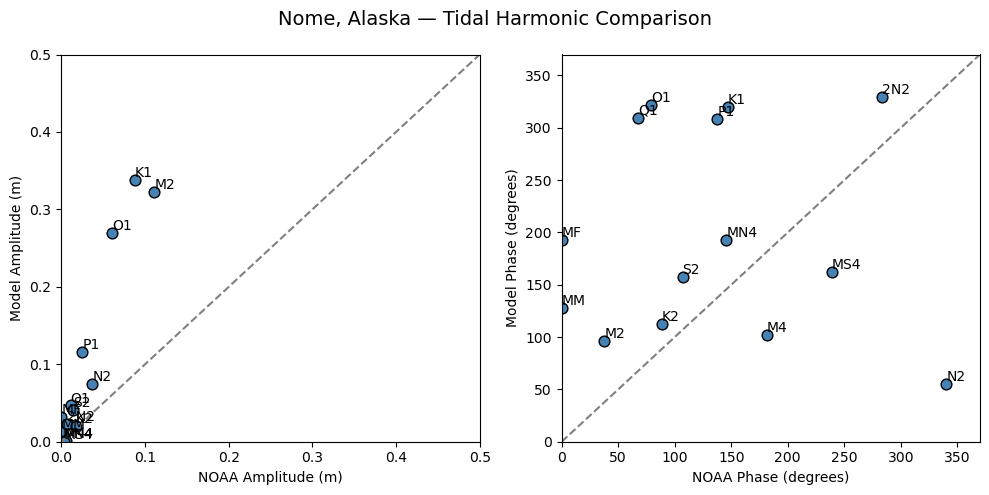

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
obs_harm = pd.read_csv(f'/scratch/tmiesse/project/noaa_data/{name}_noaa_constituents.csv')
model_amp, obs_amp = [], []
model_pha, obs_pha = [], []
# steelblue nome
# darkorange red dog
# seagreen prudhoe 
# mediumorchid unalakleet

# Scatter plot
color = "steelblue"
for i in range(len(keys)):
    amps = ncfile.variables['amp'][node_idx,i]
    phas = ncfile.variables['phs'][node_idx,i]
    oamps = obs_harm.loc[obs_harm['Constituent'] == keys[i],'Amplitude (m)'].values
    ophas = obs_harm.loc[obs_harm['Constituent'] == keys[i],'Phase (deg)'].values
    if len(oamps) > 0 and len(ophas) > 0:
        model_amp.append(amps)
        obs_amp.append(oamps[0])
        model_pha.append(phas)
        obs_pha.append(ophas[0])

        # Scatter with labels
        ax1.scatter(oamps, amps, color=color, edgecolor='k', s=60)
        ax2.scatter(ophas, phas, color=color, edgecolor='k', s=60)
        ax1.text(oamps[0], amps, keys[i], fontsize=10, ha='left', va='bottom')
        ax2.text(ophas[0], phas, keys[i], fontsize=10, ha='left', va='bottom')
lims_amps = [0, 0.5]
lims_pha = [0, 370]
ax1.plot(lims_amps, lims_amps, "--", color="gray")
ax2.plot(lims_pha, lims_pha, "--", color="gray")
ax1.set_xlim(lims_amps), ax1.set_ylim(lims_amps)
ax2.set_xlim(lims_pha), ax2.set_ylim(lims_pha)
ax2.set_ylabel("Model Phase (degrees)"),ax2.set_xlabel("NOAA Phase (degrees)")
ax1.set_ylabel("Model Amplitude (m)"),ax1.set_xlabel("NOAA Amplitude (m)")

plt.suptitle(f"{name.capitalize()}, Alaska — Tidal Harmonic Comparison", fontsize=14)
plt.tight_layout()
plt.savefig(f'/scratch/tmiesse/project/figures/{name}_harmonics.png',
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.show()